Device utilisé : cuda
Epoch 1/30 - Loss : 0.291709
Epoch 2/30 - Loss : 0.114130
Epoch 3/30 - Loss : 0.091904
Epoch 4/30 - Loss : 0.077734
Epoch 5/30 - Loss : 0.068567
Epoch 6/30 - Loss : 0.062986
Epoch 7/30 - Loss : 0.059191
Epoch 8/30 - Loss : 0.056591
Epoch 9/30 - Loss : 0.054466
Epoch 10/30 - Loss : 0.052987
Epoch 11/30 - Loss : 0.051698
Epoch 12/30 - Loss : 0.050694
Epoch 13/30 - Loss : 0.049751
Epoch 14/30 - Loss : 0.049020
Epoch 15/30 - Loss : 0.048319
Epoch 16/30 - Loss : 0.047824
Epoch 17/30 - Loss : 0.047278
Epoch 18/30 - Loss : 0.046882
Epoch 19/30 - Loss : 0.046356
Epoch 20/30 - Loss : 0.046054
Epoch 21/30 - Loss : 0.045662
Epoch 22/30 - Loss : 0.045380
Epoch 23/30 - Loss : 0.045112
Epoch 24/30 - Loss : 0.044818
Epoch 25/30 - Loss : 0.044568
Epoch 26/30 - Loss : 0.044339
Epoch 27/30 - Loss : 0.044087
Epoch 28/30 - Loss : 0.043895
Epoch 29/30 - Loss : 0.043706
Epoch 30/30 - Loss : 0.043595


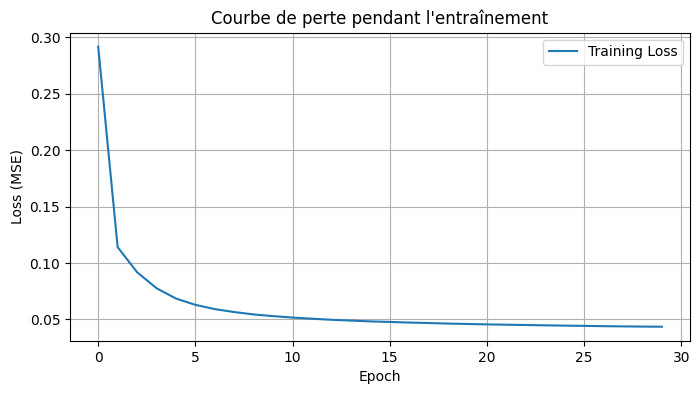

MSE entre bruit réel et bruit prédit : 0.031527


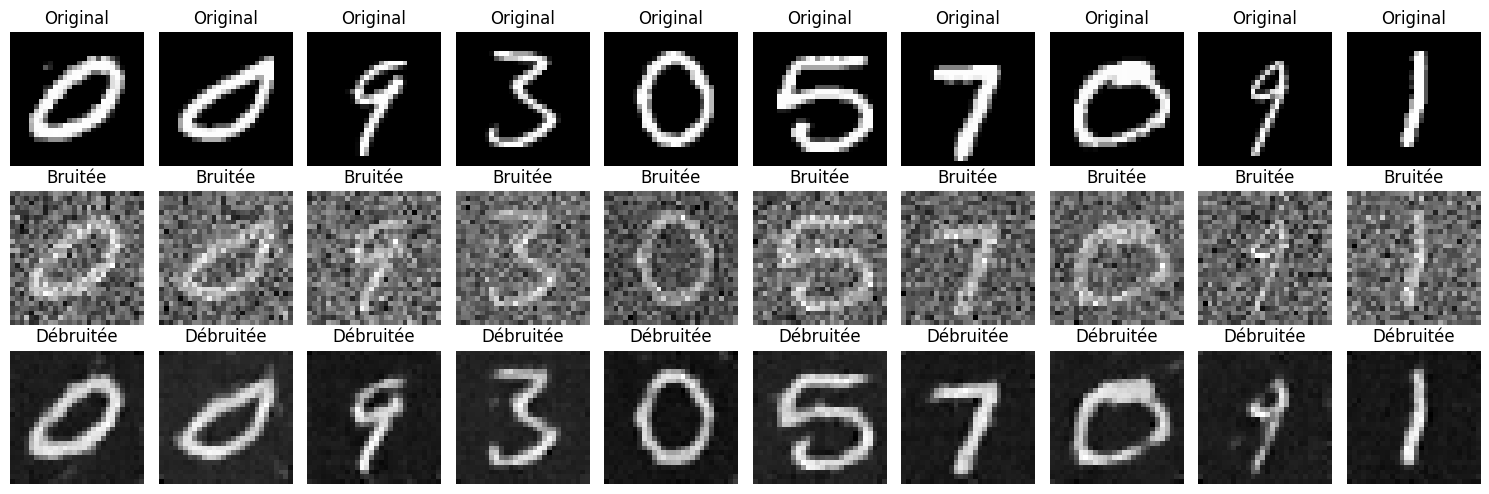

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score

# Utiliser GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {device}")

# 1. Charger un sous-ensemble de MNIST avec normalisation [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # pixels ∈ [-1, 1]
])
dataset = datasets.MNIST(root="./", train=True, transform=transform, download=True)
subset = Subset(dataset, range(30000))
loader = DataLoader(subset, batch_size=128, shuffle=True)

# 2. Définir le modèle CNN (séparé en encoder / decoder, sans classe)
encoder = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),     # [B, 32, 28, 28]
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [B, 64, 14, 14]
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # [B, 128, 7, 7]
    nn.ReLU()
)

decoder = nn.Sequential(
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, 64, 14, 14]
    nn.ReLU(),
    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # [B, 32, 28, 28]
    nn.ReLU(),
    nn.Conv2d(32, 1, kernel_size=3, padding=1)  # [B, 1, 28, 28]
)

encoder = encoder.to(device)
decoder = decoder.to(device)
# Regrouper les paramètres pour l’optimiseur
model_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(model_params, lr=1e-4)
criterion = nn.MSELoss()

# 3. Entraîner le modèle à prédire le bruit inverse
def train_epoch(encoder, decoder, loader, optimizer):
    encoder.train()
    decoder.train()
    running_loss = 0
    count = 0
    for img, _ in loader:
        img = img.to(device)
        noise = torch.randn_like(img) * 0.7
        noisy_img = img + noise
        optimizer.zero_grad()
        encoded = encoder(noisy_img)
        pred = decoder(encoded)
        loss = criterion(pred, noise)  # sortie = [B, 1, 28, 28]
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        count += 1
    return running_loss / count

# Boucle d'entraînement avec affichage des pertes
losses = []
for epoch in range(30):
    epoch_loss = train_epoch(encoder, decoder, loader, optimizer)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/30 - Loss : {epoch_loss:.6f}")

# 4. Tracer la courbe d'entraînement
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Courbe de perte pendant l'entraînement")
plt.legend()
plt.grid(True)
plt.show()

# 5. Évaluer le modèle sur un batch de test
encoder.eval()
decoder.eval()
with torch.no_grad():
    test_images, test_labels = next(iter(loader))
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)
    test_noise = torch.randn_like(test_images) * 0.7
    noisy_test_images = test_images + test_noise
    predicted_corrections = decoder(encoder(noisy_test_images))
    denoised_images = noisy_test_images - predicted_corrections
    mse = criterion(predicted_corrections, test_noise)
    print(f"MSE entre bruit réel et bruit prédit : {mse:.6f}")

# 6. Visualiser quelques résultats
test_images = test_images.cpu()
noisy_test_images = noisy_test_images.cpu()
denoised_images = denoised_images.cpu()

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    axes[0, i].imshow(test_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")
    
    axes[1, i].imshow(noisy_test_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Bruitée")
    
    axes[2, i].imshow(denoised_images[i].squeeze(), cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title("Débruitée")

plt.tight_layout()
plt.show()


## Script d’ablation sur σ (entraînement et évaluation)
Ce script va :

Entraîner plusieurs modèles pour différents σ (niveaux de bruit)

Stocker la perte et la capacité de débruitage

Tracer ##

=== Training for σ = 0.1 ===
σ=0.1 | Epoch 1 - Loss: 0.008865
σ=0.1 | Epoch 2 - Loss: 0.004687
σ=0.1 | Epoch 3 - Loss: 0.003451
σ=0.1 | Epoch 4 - Loss: 0.003064
σ=0.1 | Epoch 5 - Loss: 0.002855
σ=0.1 | Epoch 6 - Loss: 0.002710
σ=0.1 | Epoch 7 - Loss: 0.002600
σ=0.1 | Epoch 8 - Loss: 0.002506
σ=0.1 | Epoch 9 - Loss: 0.002434
σ=0.1 | Epoch 10 - Loss: 0.002372
=== Training for σ = 0.3 ===
σ=0.3 | Epoch 1 - Loss: 0.070426
σ=0.3 | Epoch 2 - Loss: 0.030095
σ=0.3 | Epoch 3 - Loss: 0.022641
σ=0.3 | Epoch 4 - Loss: 0.019087
σ=0.3 | Epoch 5 - Loss: 0.017042
σ=0.3 | Epoch 6 - Loss: 0.015779
σ=0.3 | Epoch 7 - Loss: 0.014871
σ=0.3 | Epoch 8 - Loss: 0.014165
σ=0.3 | Epoch 9 - Loss: 0.013628
σ=0.3 | Epoch 10 - Loss: 0.013197
=== Training for σ = 0.5 ===
σ=0.5 | Epoch 1 - Loss: 0.158238
σ=0.5 | Epoch 2 - Loss: 0.067582
σ=0.5 | Epoch 3 - Loss: 0.054654
σ=0.5 | Epoch 4 - Loss: 0.046005
σ=0.5 | Epoch 5 - Loss: 0.039972
σ=0.5 | Epoch 6 - Loss: 0.035922
σ=0.5 | Epoch 7 - Loss: 0.033310
σ=0.5 | Epoch 8 - Lo

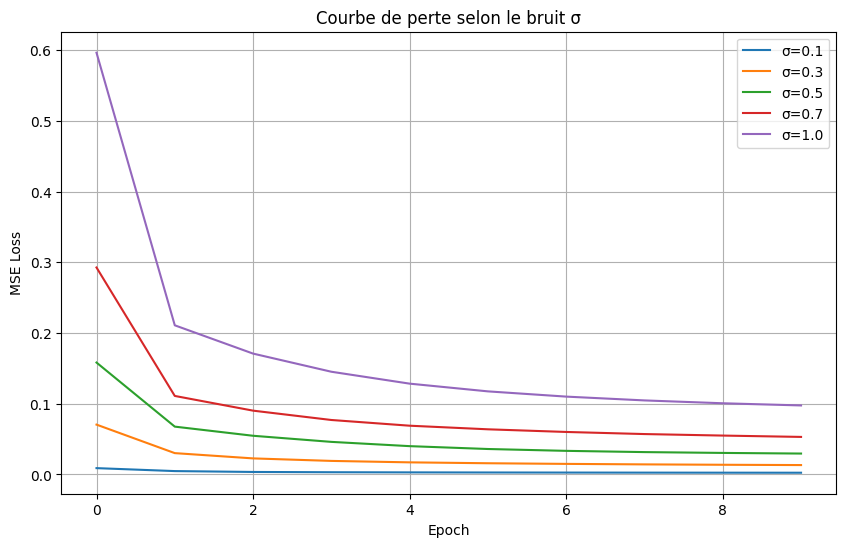

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Préparation des données (identique à ton code)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root="./", train=True, transform=transform, download=True)
subset = Subset(dataset, range(30000))
loader = DataLoader(subset, batch_size=128, shuffle=True)

# 2. Définition du modèle (identique à ton code)
def build_model():
    encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.ReLU()
    )
    decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 1, kernel_size=3, padding=1)
    )
    return encoder.to(device), decoder.to(device)

# 3. Fonction d’entraînement sur 1 epoch
def train_epoch(encoder, decoder, loader, optimizer, sigma, criterion):
    encoder.train()
    decoder.train()
    running_loss = 0
    count = 0
    for img, _ in loader:
        img = img.to(device)
        noise = torch.randn_like(img) * sigma
        noisy_img = img + noise
        optimizer.zero_grad()
        encoded = encoder(noisy_img)
        pred = decoder(encoded)
        loss = criterion(pred, noise)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        count += 1
    return running_loss / count

# 4. Ablation sur plusieurs valeurs de sigma
sigmas = [0.1, 0.3, 0.5, 0.7, 1.0]
results = {}

for sigma in sigmas:
    print(f"=== Training for σ = {sigma} ===")
    encoder, decoder = build_model()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
    criterion = nn.MSELoss()
    losses = []
    for epoch in range(10):  # Réduire epochs si test rapide
        epoch_loss = train_epoch(encoder, decoder, loader, optimizer, sigma, criterion)
        losses.append(epoch_loss)
        print(f"σ={sigma} | Epoch {epoch+1} - Loss: {epoch_loss:.6f}")
    results[sigma] = {'encoder': encoder, 'decoder': decoder, 'losses': losses}

# 5. Tracer la courbe de perte pour chaque sigma
plt.figure(figsize=(10,6))
for sigma in sigmas:
    plt.plot(results[sigma]['losses'], label=f'σ={sigma}')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Courbe de perte selon le bruit σ')
plt.legend()
plt.grid(True)
plt.show()


##  Script de visualisation des champs de vecteurs (quiver plot sur PCA)
Ce script montre, dans l’espace 2D réduit, comment les vecteurs de correction du bruit "guident" les points vers des clusters. ##

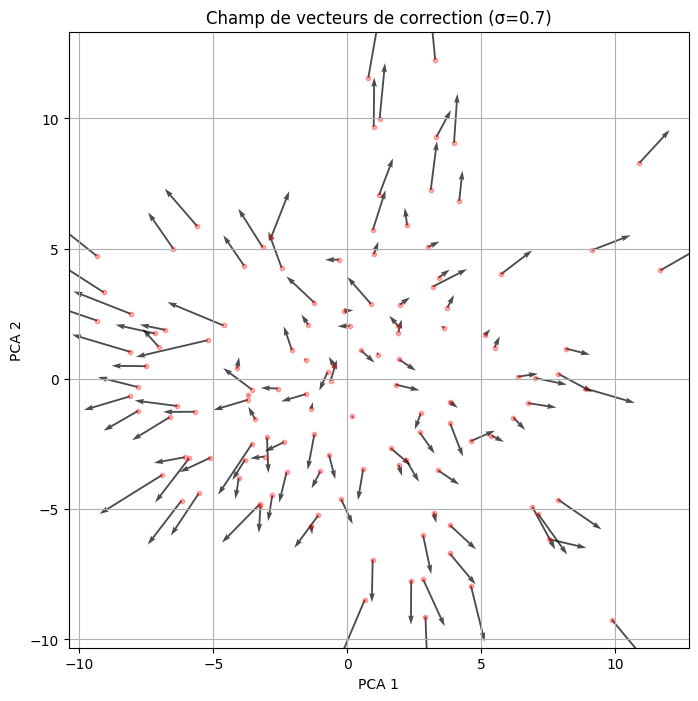

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_quiver_field(encoder, decoder, loader, sigma, nb_points=300):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        imgs, _ = next(iter(loader))
        imgs = imgs[:nb_points].to(device)
        noise = torch.randn_like(imgs) * sigma
        noisy_imgs = imgs + noise
        pred_noise = decoder(encoder(noisy_imgs)).cpu()
        correction = pred_noise.view(pred_noise.size(0), -1).numpy()
        positions = noisy_imgs.cpu().view(noisy_imgs.size(0), -1).numpy()

        
        # PCA pour réduction en 2D
        pca = PCA(n_components=2)
        positions_2d = pca.fit_transform(positions)
        vectors_2d = pca.transform(positions + correction) - positions_2d
        
        plt.figure(figsize=(8, 8))
        plt.quiver(positions_2d[:,0], positions_2d[:,1], vectors_2d[:,0], vectors_2d[:,1],
                   angles='xy', scale_units='xy', scale=1, width=0.003, alpha=0.7)
        plt.scatter(positions_2d[:,0], positions_2d[:,1], s=10, color='r', alpha=0.3)
        plt.title(f'Champ de vecteurs de correction (σ={sigma})')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.grid(True)
        plt.show()

plot_quiver_field(results[0.7]['encoder'], results[0.7]['decoder'], loader, sigma=0.7)


In [4]:
def flow_denoise(x_init, encoder, decoder, steps=10):
    x = x_init.clone().to(device)
    with torch.no_grad():
        for _ in range(steps):
            epsilon_hat = decoder(encoder(x))
            x = x - epsilon_hat 
    return x.cpu().view(x.size(0), -1) 


In [7]:
from sklearn.cluster import AgglomerativeClustering

def cluster_from_flow(encoder, decoder, loader, n_clusters=128, steps=10, sigma=0.7):
    imgs, labels = next(iter(loader))
    imgs = imgs.to(device)
    noise = torch.randn_like(imgs) * sigma
    noisy = imgs + noise
    x_final = flow_denoise(noisy, encoder, decoder, steps=steps)
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(x_final)
    return cluster_labels, labels[:len(cluster_labels)].numpy(), x_final


In [8]:
from sklearn.metrics import normalized_mutual_info_score

pred_labels, true_labels, _ = cluster_from_flow(encoder, decoder, loader)
nmi = normalized_mutual_info_score(true_labels, pred_labels)
print(f"NMI après clustering orienté par le débruitage : {nmi:.4f}")


NMI après clustering orienté par le débruitage : 0.6375
